In [ ]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:23<00:00,  5.44it/s]


In [ ]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = ""
    for conv in convos:
        if conv["role"] == "user":
            user_prompts = user_prompts + " " + conv["text"].lower()
    if user_prompts == "":
      continue
    prompts.append(user_prompts)
    code2prompts[code] = user_prompts

In [ ]:
answers = []
code2answers= defaultdict(list)
for code , convos in code2convos.items():
    gpt_ans = ""
    for conv in convos:
        if conv["role"] == "assistant":
            gpt_ans = gpt_ans + " " + conv["text"].lower()
    if gpt_ans == "":
      continue
    answers.append([gpt_ans])
    code2answers[code] = gpt_ans

In [ ]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


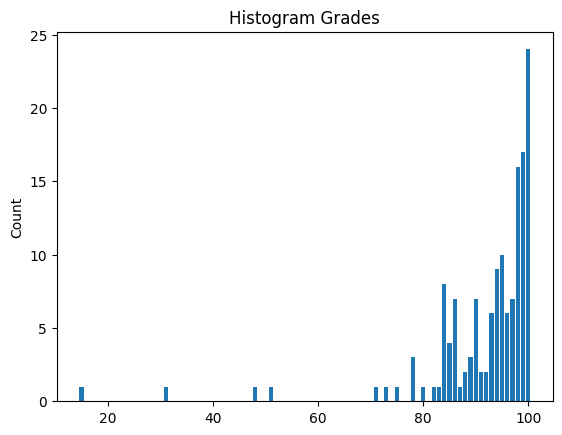

In [ ]:
plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
code_prompts = pd.DataFrame(code2prompts, index=[0]).T
code_prompts.reset_index(inplace=True)
code_prompts.rename(columns={0: "prompts"}, inplace=True)
code_prompts.rename(columns={"index" : "code"}, inplace=True)

In [ ]:
code_ans = pd.DataFrame(code2answers, index=[0]).T
code_ans.reset_index(inplace=True)
code_ans.rename(columns={0: "answers"}, inplace=True)
code_ans.rename(columns={"index" : "code"}, inplace=True)

In [ ]:
df_prompt = pd.merge(code_prompts, scores, on="code", how="left")
df_prompt.head()

,code,prompts,grade,grade_bin
0,0031c86e-81f4-4eef-9e0e-28037abf9883,load a csv file into a pandas in python. the ...,48.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,i have a dataset that contains the following ...,99.0,4.0
2,041f950b-c013-409a-a642-cffff60b9d4b,i have a csv file data with columns:\n\nspeci...,90.0,1.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,how can i display variable names in a pandas ...,97.0,4.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,i am doing a machine leraning homework using ...,100.0,4.0


In [ ]:
df_prompt.dropna(inplace=True)
df_prompt.drop_duplicates("code",inplace=True, keep="first")

In [ ]:
df_ans = pd.merge(code_ans, scores, on="code", how="left")
df_ans.head()

,code,answers,grade,grade_bin
0,0031c86e-81f4-4eef-9e0e-28037abf9883,you can load a csv file into a pandas datafra...,48.0,0.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,great! it looks like you have a comprehensive...,99.0,4.0
2,041f950b-c013-409a-a642-cffff60b9d4b,certainly! let's go through each step.step 1:...,90.0,1.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,"in pandas, you can display variable (column) ...",97.0,4.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,absolutely! here's the code to import the nec...,100.0,4.0


In [ ]:
df_ans.dropna(inplace=True)
df_ans.drop_duplicates("code",inplace=True, keep="first")

In [ ]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(df_prompt['prompts'], df_prompt['grade'], test_size=0.2, random_state=42)
print("Train set size:", len(X_train_p))
print("Test set size:", len(X_test_p))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_ans['answers'], df_ans['grade'], test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


# BoW

## for grade

In [ ]:
#ANSWERS
from sklearn.feature_extraction.text import CountVectorizer

max_features = 1000
vectorizer = CountVectorizer(max_features=max_features, preprocessor=lambda x: x)

# Fit the vectorizer to your train data
vectorizer.fit(X_train)

# Transform the train and test data
train_bow = vectorizer.transform(X_train).toarray()
test_bow = vectorizer.transform(X_test).toarray()

In [ ]:
#PROMPTS
from sklearn.feature_extraction.text import CountVectorizer

max_features = 1000
vectorizer_p = CountVectorizer(max_features=max_features, preprocessor=lambda x: x)

# Fit the vectorizer to your train data
vectorizer_p.fit(X_train_p)

# Transform the train and test data
train_bow_p = vectorizer_p.transform(X_train_p).toarray()
test_bow_p = vectorizer_p.transform(X_test_p).toarray()

# TF-IDF

## for grade

In [ ]:
# ANSWERS
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 1000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)
tfidf_vectorizer.fit(X_train)

# Transform the train and test data
train_tfidf = tfidf_vectorizer.transform(X_train).toarray()
test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [ ]:
# PROMPTS
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 1000
tfidf_vectorizer_p = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)
tfidf_vectorizer_p.fit(X_train_p)

# Transform the train and test data
train_tfidf_p = tfidf_vectorizer_p.transform(X_train_p).toarray()
test_tfidf_p = tfidf_vectorizer_p.transform(X_test_p).toarray()

# Word2Vec

In [ ]:
import gensim.downloader
from gensim.models import Word2Vec

In [ ]:
# Loading pretrained Word2Vec model (Word embeddings)
model_name = "glove-wiki-gigaword-100"
word_to_vec = gensim.downloader.load(model_name)

[==================================================] 100.0% 128.1/128.1MB downloaded


## for grade

In [ ]:
# ANSWERS
# Converting sentences to list of words
sentences = [sentence.split() for sentence in X_train]

# Training model
vector_size = 10
window = 5
min_count = 5

word_to_vec = Word2Vec(
    sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

# PROMPTS
sentences_p = [sentence.split() for sentence in X_train_p]

# Training model
vector_size = 10
window = 5
min_count = 5

word_to_vec_p = Word2Vec(
    sentences_p,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# This function should convert each review to a fixed-sized vector representation
def vectorize(review, word_to_vec):
    words = review.split()
    # Remove words that are not in the Word2Vec model's vocabulary
    words = [word for word in words if word in word_to_vec.wv]

    if len(words) == 0:
        # If no words are present in the Word2Vec model's vocabulary, return a zero vector
        return np.zeros_like(word_to_vec.wv["word"])

    # Calculate the average of word vectors
    review_vector = np.mean([word_to_vec.wv[word] for word in words], axis=0)
    return review_vector

# Applying your function to convert the train and test reviews to vector representations
train_word2vec = np.array([vectorize(review, word_to_vec) for review in X_train])
test_word2vec = np.array([vectorize(review, word_to_vec) for review in X_test])

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# This function should convert each review to a fixed-sized vector representation
def vectorize(review, word_to_vec):
    words = review.split()
    # Remove words that are not in the Word2Vec model's vocabulary
    words = [word for word in words if word in word_to_vec.wv]

    if len(words) == 0:
        # If no words are present in the Word2Vec model's vocabulary, return a zero vector
        return np.zeros_like(word_to_vec.wv["word"])

    # Calculate the average of word vectors
    review_vector = np.mean([word_to_vec.wv[word] for word in words], axis=0)
    return review_vector

# Applying your function to convert the train and test reviews to vector representations
train_word2vec_p = np.array([vectorize(review, word_to_vec_p) for review in X_train_p])
test_word2vec_p = np.array([vectorize(review, word_to_vec_p) for review in X_test_p])

# Regressor

## BoW

In [ ]:
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


DTregr = DecisionTreeRegressor()
DTregr.fit(train_bow, y_train)
DTregr_p = DecisionTreeRegressor()
DTregr_p.fit(train_bow_p, y_train_p)

RFregr = RandomForestRegressor()
RFregr.fit(train_bow, y_train)
RFregr_p = RandomForestRegressor()
RFregr_p.fit(train_bow_p, y_train_p)


SGDregr = SGDRegressor()
SGDregr.fit(train_bow, y_train)
SGDregr_p = SGDRegressor()
SGDregr_p.fit(train_bow_p, y_train_p)

SGDRegressor()

In [ ]:
DTpreds = DTregr.predict(test_bow)
DTpreds_p = DTregr_p.predict(test_bow_p)

RFpreds = RFregr.predict(test_bow)
RFpreds_p = RFregr_p.predict(test_bow_p)

SGDpreds = SGDregr.predict(test_bow)
SGDpreds_p = SGDregr_p.predict(test_bow_p)

## TF-IDF

In [ ]:
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


DTregr = DecisionTreeRegressor()
DTregr.fit(train_tfidf, y_train)
DTregr_p = DecisionTreeRegressor()
DTregr_p.fit(train_tfidf_p, y_train_p)

RFregr = RandomForestRegressor()
RFregr.fit(train_tfidf, y_train)
RFregr_p = RandomForestRegressor()
RFregr_p.fit(train_tfidf_p, y_train_p)


SGDregr = SGDRegressor()
SGDregr.fit(train_tfidf, y_train)
SGDregr_p = SGDRegressor()
SGDregr_p.fit(train_tfidf_p, y_train_p)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor()

In [ ]:
DTpreds = DTregr.predict(test_tfidf)
DTpreds_p = DTregr_p.predict(test_tfidf_p)

RFpreds = RFregr.predict(test_tfidf)
RFpreds_p = RFregr_p.predict(test_tfidf_p)

SGDpreds = SGDregr.predict(test_tfidf)
SGDpreds_p = SGDregr_p.predict(test_tfidf_p)

## W2V

In [ ]:
from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


DTregr = DecisionTreeRegressor()
DTregr.fit(train_word2vec, y_train)
DTregr_p = DecisionTreeRegressor()
DTregr_p.fit(train_word2vec_p, y_train_p)

RFregr = RandomForestRegressor()
RFregr.fit(train_word2vec, y_train)
RFregr_p = RandomForestRegressor()
RFregr_p.fit(train_word2vec_p, y_train_p)


SGDregr = SGDRegressor()
SGDregr.fit(train_word2vec, y_train)
SGDregr_p = SGDRegressor()
SGDregr_p.fit(train_word2vec_p, y_train_p)

SGDRegressor()

In [ ]:
DTpreds = DTregr.predict(test_word2vec)
DTpreds_p = DTregr_p.predict(test_word2vec_p)

RFpreds = RFregr.predict(test_word2vec)
RFpreds_p = RFregr_p.predict(test_word2vec_p)

SGDpreds = SGDregr.predict(test_word2vec)
SGDpreds_p = SGDregr_p.predict(test_word2vec_p)

# Predict & Analyze

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Calculate MSE

DTmse = mean_squared_error(y_test, DTpreds)
DTmse_p =  mean_squared_error(y_test_p, DTpreds_p)
DTr2 = r2_score(y_test, DTpreds)
DTr2_p = r2_score(y_test_p, DTpreds_p)

RFmse = mean_squared_error(y_test, RFpreds)
RFmse_p =  mean_squared_error(y_test_p, RFpreds_p)
RFr2 = r2_score(y_test, RFpreds)
RFr2_p = r2_score(y_test_p, RFpreds_p)

SGDmse = mean_squared_error(y_test, SGDpreds)
SGDmse_p =  mean_squared_error(y_test_p, SGDpreds_p)
SGDr2 = r2_score(y_test, SGDpreds)
SGDr2_p = r2_score(y_test_p, SGDpreds_p)

In [ ]:
print(DTmse, DTr2)
print(DTmse_p, DTr2_p)

print(RFmse, RFr2)
print(RFmse_p, RFr2_p)

print(SGDmse, SGDr2)
print(SGDmse_p, SGDr2_p)

91.52 0.18479035430265367
180.8 -0.6104666077587437
118.93999600000001 -0.05945183564689471
156.73446399999997 -0.3961040960009119
118.33812381608602 -0.054090690434879685
103.79490463178858 0.07545227895465234


## Results
## BoW

219.76 -0.9575007838554286

368.84 -2.2854231394122513

114.32442799999997 -0.018338903457514766

89.04901199999996 0.20680055154918364

4.933060373036347e+28 -4.394097900903168e+26

3.7517651051941655e+26 -3.3418652776934034e+24

## TF-IDF

172.92 -0.5402759171108515

185.24 -0.6500156771085712

89.82310399999999 0.19990536727189812

96.99115200000004 0.1360563520793543

107.61805944960881 0.04139772602107139

135.40384367912114 -0.2061027035808043

## W2V

95.68 0.14773537040731977

176.48 -0.5719864321751276

79.580604 0.2911399039420802

149.56822 -0.332271149844654

114.94820901274053 -0.023895200424177476

109.57511060765405 0.02396539449614077

Best ones from
- bow -> RF from prompts
- tfidf ->RF from answers
- w2v -> RF from answers

# Ensemble

In [ ]:
best_bow = RFpreds_p.copy()

In [ ]:
best_tfidf = DTpreds_p.copy()

In [ ]:
best_w2v = DTpreds.copy()

In [ ]:
ensemble = (best_bow*0.4+best_tfidf*0.3+best_tfidf*0.3)

In [ ]:
mean_squared_error(y_test, ensemble)

60.82595776

In [ ]:
r2_score(y_test,ensemble)

0.4581959410540717

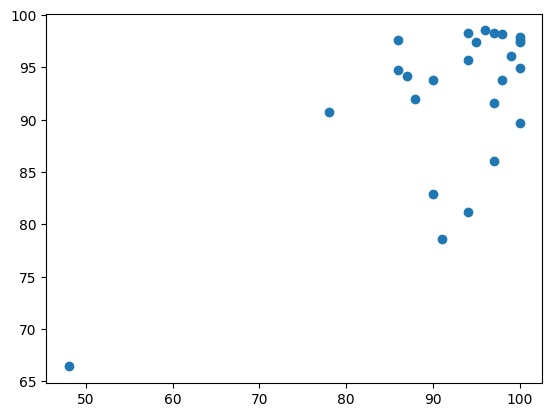

In [ ]:
plt.scatter(y_test, ensemble)